In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx
import itertools
import math as m
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
import seaborn as sns

In [2]:
import ranking_funcs

/Users/wangning/opt/anaconda3/envs/cpsc330/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df_un_factor=pd.read_csv('ranking_data_sets/imdb_movie_stars_v3.csv')
df = ranking_funcs.factor_imdb(df_un_factor.copy())

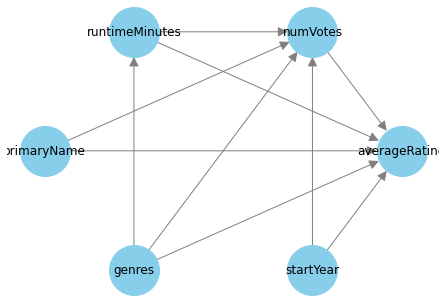

In [4]:
G = nx.DiGraph()

nodes = ["averageRating", "numVotes", "runtimeMinutes", "primaryName", "genres"]
G.add_nodes_from(nodes)


edges = [
    ("primaryName", "averageRating"), 
    ("primaryName", "numVotes"),
    ("numVotes", "averageRating"),
    ("runtimeMinutes", "numVotes"),
    ("runtimeMinutes", "averageRating"),
    ("genres", "numVotes"),
    ("genres", "runtimeMinutes"),
    ("genres", "averageRating"),
    ("startYear", "averageRating"),
    ("startYear", "numVotes")
]
G.add_edges_from(edges)


layout = nx.circular_layout(G)

nx.draw(G, with_labels=True, node_color='skyblue', node_size=2500, edge_color='gray', arrowsize=20, pos=layout)

In [5]:
new_G_combined=ranking_funcs.get_new_G_combined(G,df)
new_G_combined_rf=ranking_funcs.get_new_G_combined_rf(G,df)

In [6]:
updated_df=ranking_funcs.get_ranking_query(new_G_combined, df, len(df), {'numVotes':3}, 'averageRating',
                         {'primaryName':10},"fix")

X=df[["numVotes", "runtimeMinutes", "primaryName", "genres", "startYear"]]
y=df["averageRating"]

updated_df_X=updated_df[["numVotes", "runtimeMinutes", "primaryName", "genres", "startYear"]]
updated_df_y=updated_df["averageRating"]

In [7]:
rf_estimator=RandomForestRegressor(random_state=1234).fit(X, y)
rf_result=rf_estimator.predict(updated_df_X)
updated_df['rf_prediction']=rf_result
rf_order=updated_df.sort_values(by='rf_prediction',ascending=False)
rf_order

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,tconst_y,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,rf_prediction
140,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0108052,tt0108052,9.0,3,tt0108052,movie,Schindler's List,Schindler's List,0,0,\N,2,2,8.323119
127,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0083987,tt0083987,8.0,3,tt0083987,movie,Gandhi,Gandhi,0,0,\N,2,2,8.323119
216,nm0424060,0,1984,\N,"actress,soundtrack,producer","tt0335266,tt1798709,tt1441395,tt0848228",tt0482571,tt0482571,8.5,3,tt0482571,movie,The Prestige,The Prestige,0,1,\N,1,2,8.009540
213,nm0424060,0,1984,\N,"actress,soundtrack,producer","tt0335266,tt1798709,tt1441395,tt0848228",tt0416320,tt0416320,7.6,3,tt0416320,movie,Match Point,Match Point,0,1,\N,1,2,8.009540
401,nm1165110,11,1983,\N,"actor,producer,soundtrack","tt0796366,tt1735898,tt3501632,tt0848228",tt4154796,tt4154796,8.4,3,tt4154796,movie,Avengers: Endgame,Avengers: Endgame,0,2,\N,2,1,7.895111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0318081,tt0318081,4.2,1,tt0318081,movie,A Sound of Thunder,A Sound of Thunder,0,1,\N,0,1,4.265481
163,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0462396,tt0462396,5.4,1,tt0462396,movie,The Last Legion,The Last Legion,0,1,\N,0,1,4.265481
150,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0167456,tt0167456,4.3,1,tt0167456,movie,Thunderbirds,Thunderbirds,0,1,\N,0,1,4.265481
418,nm3053338,2,1990,\N,"actress,producer,soundtrack","tt7713068,tt0993846,tt1386697,tt5580036",tt1475569,tt1475569,2.5,0,tt1475569,movie,I.C.U.,I.C.U.,0,1,\N,0,4,4.007667


In [8]:
X_const = sm.add_constant(X)
updated_X_const = sm.add_constant(updated_df_X)
ols_model = sm.OLS(y, X_const).fit()
ols_result = ols_model.predict(updated_X_const)
updated_df['ols_prediction']=ols_result
ols_order=updated_df.sort_values(by='ols_prediction',ascending=False)

In [9]:
backdoor_1_preds_cg=ranking_funcs.predict_backdoor_opt(new_G_combined_rf, df, len(df), {'numVotes':3}, 'averageRating',
                         {'primaryName':10},"fix")

backdoor_2_preds_cg=ranking_funcs.predict_backdoor_opt2(new_G_combined_rf, df, len(df), {'numVotes':3}, 'averageRating',
                         {'primaryName':10},"fix")

In [10]:
rf_results=[]
rf_results_in_topk=[]

ols_results = []
ols_results_in_topk = []

back_door_opt1_with_combined_G=[]
back_door_opt1_with_combined_G_in_topk=[]

back_door_opt2_with_combined_G=[]
back_door_opt2_with_combined_G_in_topk=[]

for i in range(1,len(updated_df)+1):
    rf_results.append(ranking_funcs.accuracy_topk_rank(rf_order.head(i).index,updated_df.head(i).index))
    rf_results_in_topk.append(ranking_funcs.accuracy_in_topk(rf_order.head(i).index,updated_df.head(i).index))
    
    ols_results.append(ranking_funcs.accuracy_topk_rank(ols_order.head(i).index,updated_df.head(i).index))
    ols_results_in_topk.append(ranking_funcs.accuracy_in_topk(ols_order.head(i).index,updated_df.head(i).index))
    
    back_door_opt1_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_1_preds_cg['row_index'].head(i).to_list(),updated_df.head(i).index))
    back_door_opt1_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_1_preds_cg['row_index'].head(i).to_list(),updated_df.head(i).index))
    
    back_door_opt2_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_2_preds_cg['row_index'].head(i).to_list(),updated_df.head(i).index))
    back_door_opt2_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_2_preds_cg['row_index'].head(i).to_list(),updated_df.head(i).index))

In [11]:
df_top_k_accuracy=pd.DataFrame({'Random forest':rf_results,'linear regression':ols_results,
                               'Hyper:Backdoor Criterion':back_door_opt1_with_combined_G,
                                'Hyper:BSCPM':back_door_opt2_with_combined_G,
                               'Top_k_range':range(1,len(updated_df)+1)})

df_in_top_k_accuracy=pd.DataFrame({'Random forest':rf_results_in_topk,'linear regression':ols_results_in_topk,
                               'Hyper:Backdoor Criterion':back_door_opt1_with_combined_G_in_topk,
                                'Hyper:BSCPM':back_door_opt2_with_combined_G_in_topk,
                                'Top_k_range':range(1,len(updated_df)+1)})

In [12]:
df_in_top_k_accuracy.head(10)

,Random forest,linear regression,Hyper:Backdoor Criterion,Hyper:BSCPM,Top_k_range
0,1.000000,0.000000,1.000000,1.000000,1
1,0.500000,0.500000,0.500000,0.500000,2
2,0.666667,0.333333,0.333333,0.333333,3
3,0.500000,0.250000,0.250000,0.500000,4
4,0.600000,0.200000,0.200000,0.600000,5
5,0.500000,0.166667,0.166667,0.500000,6
6,0.428571,0.142857,0.142857,0.428571,7
7,0.375000,0.125000,0.125000,0.625000,8
8,0.333333,0.222222,0.111111,0.666667,9
9,0.300000,0.200000,0.100000,0.600000,10


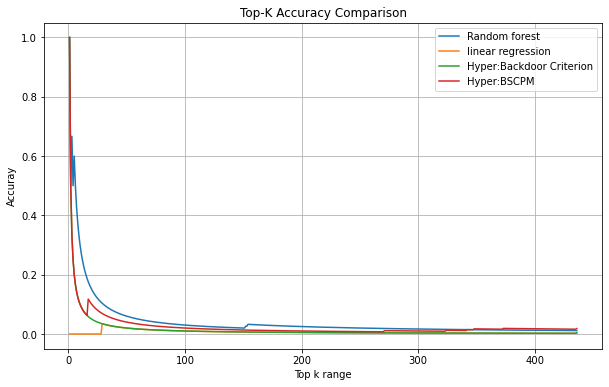

In [13]:
plt.figure(figsize=(10, 6))
for column in df_top_k_accuracy.columns[:-1]:
    plt.plot(df_top_k_accuracy["Top_k_range"], df_top_k_accuracy[column], label=column)

plt.xlabel("Top k range")
plt.ylabel("Accuray")
plt.title("Top-K Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.savefig(f'ranking_plots/top_k_comparison.png')

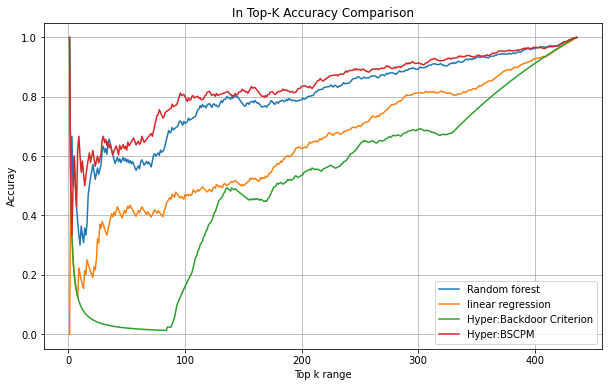

In [14]:
plt.figure(figsize=(10, 6))
for column in df_in_top_k_accuracy.columns[:-1]:
    plt.plot(df_in_top_k_accuracy["Top_k_range"], df_in_top_k_accuracy[column], label=column)

plt.xlabel("Top k range")
plt.ylabel("Accuray")
plt.title("In Top-K Accuracy Comparison")
plt.legend()
plt.grid(True)
plt.savefig(f'ranking_plots/In_top_k_comparison.png')
plt.show()

In [15]:
updated_df['true_row_index']=updated_df.index
rf_order['true_row_index']=rf_order.index
ols_order['true_row_index']=ols_order.index
merged_df=backdoor_2_preds_cg.merge(updated_df,how='left', right_index=True,left_on='row_index')
merged_df['true_row_index']=merged_df.index

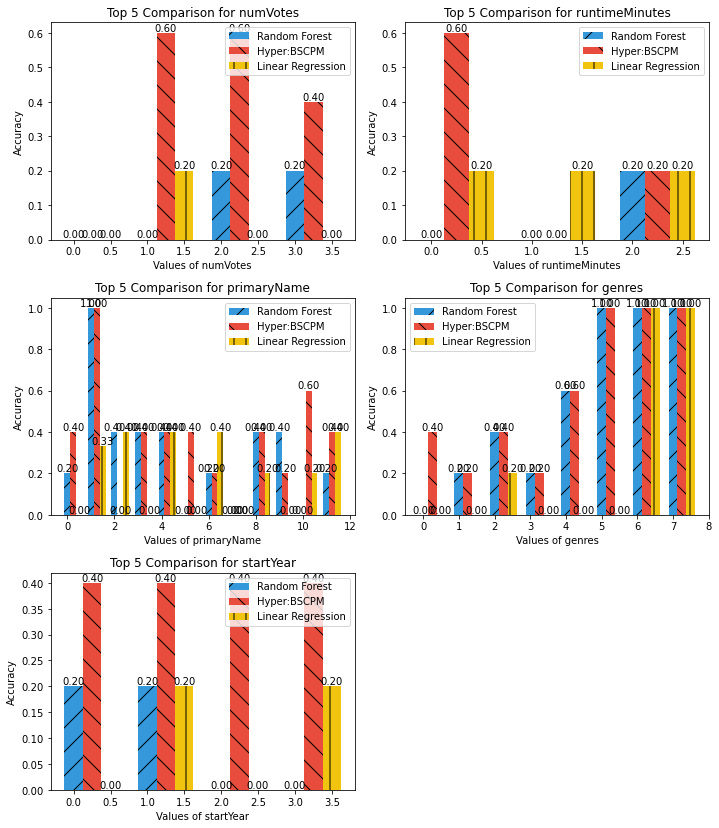

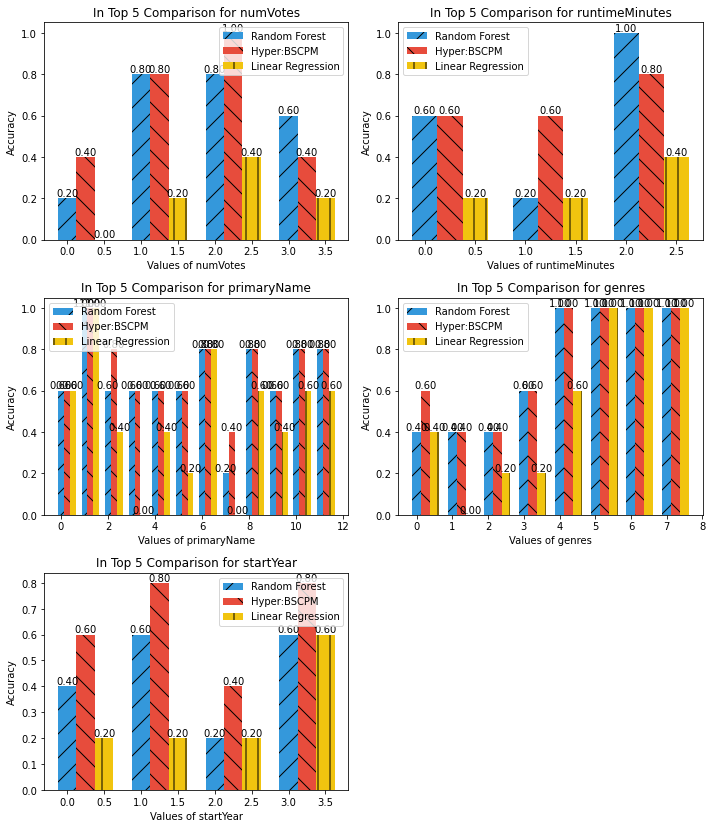

In [16]:
Xs = ["numVotes", "runtimeMinutes", "primaryName", "genres", "startYear"]


plt.figure(figsize=(10, 3 * len(Xs)))

colors = {
    'random_forest': '#3498db', 
    'backdoor_method2_with_combined_effect': '#e74c3c', 
    'OLS': '#f1c40f' 
}

hatches = ['/', '\\', '|', '-']


for index, x in enumerate(Xs, start=1):
    rf_results=[]
    rf_results_in_topk=[]
    back_door_opt2_with_combined_G=[]
    back_door_opt2_with_combined_G_in_topk=[]
    ols_results = []  
    ols_results_in_topk = [] 
    x_val=[]
    
    true_row_indexes=updated_df.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    rf_row_indexes=rf_order.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    backdoor_2_row_indexes=merged_df.groupby(x).apply(lambda d: d['row_index'].to_list())
    ols_row_indexes = ols_order.groupby(x).apply(lambda d: d['true_row_index'].to_list()) 
    
    
    for i in range(len(true_row_indexes)):
        rf_results.append(ranking_funcs.accuracy_topk_rank(rf_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        rf_results_in_topk.append(ranking_funcs.accuracy_in_topk(rf_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        
        back_door_opt2_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_2_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        back_door_opt2_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_2_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        
        ols_results.append(ranking_funcs.accuracy_topk_rank(ols_row_indexes[i][0:5], true_row_indexes[i][0:5])) 
        ols_results_in_topk.append(ranking_funcs.accuracy_in_topk(ols_row_indexes[i][0:5], true_row_indexes[i][0:5])) 
        
        x_val.append(true_row_indexes.index[i])
        
    
    df_top_k_accuracy=pd.DataFrame({'random_forest':rf_results,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G,
                                    'OLS': ols_results,x:x_val})
    df_in_top_k_accuracy=pd.DataFrame({'random_forest':rf_results_in_topk,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G_in_topk,
                                       'OLS': ols_results_in_topk,x:x_val})
    
    plt.subplot(4, 2, index)
    bar_width = 0.25
    r1 = np.arange(len(df_top_k_accuracy))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    bars1 = plt.bar(r1, df_top_k_accuracy['random_forest'], width=bar_width, color=colors['random_forest'], label='Random Forest', hatch=hatches[0])
    bars2 = plt.bar(r2, df_top_k_accuracy['backdoor_method2_with_combined_effect'], width=bar_width, 
                    color=colors['backdoor_method2_with_combined_effect'], label='Hyper:BSCPM', hatch=hatches[1])
    bars3 = plt.bar(r3, df_top_k_accuracy['OLS'], width=bar_width, color=colors['OLS'], label='Linear Regression', hatch=hatches[2])
    
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.2f}', va='bottom', ha='center')

            
    plt.xlabel(f'Values of {x}')
    plt.ylabel('Accuracy')
    plt.title(f'Top 5 Comparison for {x}')
    plt.legend()
    
plt.tight_layout()
plt.savefig('ranking_plots/top_5_comparison_all_features.png')
plt.show()



plt.figure(figsize=(10, 3 * len(Xs)))

# Iterate for In Top 5 Comparison plots
for index, x in enumerate(Xs, start=1):
    rf_results=[]
    rf_results_in_topk=[]
    back_door_opt2_with_combined_G=[]
    back_door_opt2_with_combined_G_in_topk=[]
    ols_results = []  
    ols_results_in_topk = [] 
    x_val=[]
    
    true_row_indexes=updated_df.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    rf_row_indexes=rf_order.groupby(x).apply(lambda d: d['true_row_index'].to_list())
    backdoor_2_row_indexes=merged_df.groupby(x).apply(lambda d: d['row_index'].to_list())
    ols_row_indexes = ols_order.groupby(x).apply(lambda d: d['true_row_index'].to_list()) 
    
    
    for i in range(len(true_row_indexes)):
        rf_results.append(ranking_funcs.accuracy_topk_rank(rf_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        rf_results_in_topk.append(ranking_funcs.accuracy_in_topk(rf_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        
        back_door_opt2_with_combined_G.append(ranking_funcs.accuracy_topk_rank(backdoor_2_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        back_door_opt2_with_combined_G_in_topk.append(ranking_funcs.accuracy_in_topk(backdoor_2_row_indexes[i][0:5],true_row_indexes[i][0:5]))
        
        ols_results.append(ranking_funcs.accuracy_topk_rank(ols_row_indexes[i][0:5], true_row_indexes[i][0:5])) 
        ols_results_in_topk.append(ranking_funcs.accuracy_in_topk(ols_row_indexes[i][0:5], true_row_indexes[i][0:5])) 
        
        x_val.append(true_row_indexes.index[i])
        
    
    df_top_k_accuracy=pd.DataFrame({'random_forest':rf_results,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G,
                                    'OLS': ols_results,x:x_val})
    df_in_top_k_accuracy=pd.DataFrame({'random_forest':rf_results_in_topk,'backdoor_method2_with_combined_effect':back_door_opt2_with_combined_G_in_topk,
                                       'OLS': ols_results_in_topk,x:x_val})
    plt.subplot(4, 2, index)
    bar_width = 0.25
    r1 = np.arange(len(df_in_top_k_accuracy))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    bars1 = plt.bar(r1, df_in_top_k_accuracy['random_forest'], width=bar_width, color=colors['random_forest'], label='Random Forest', hatch=hatches[0])
    bars2 = plt.bar(r2, df_in_top_k_accuracy['backdoor_method2_with_combined_effect'], width=bar_width, 
                    color=colors['backdoor_method2_with_combined_effect'], label='Hyper:BSCPM', hatch=hatches[1])
    bars3 = plt.bar(r3, df_in_top_k_accuracy['OLS'], width=bar_width, color=colors['OLS'], label='Linear Regression', hatch=hatches[2])
    
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2.0, yval, f'{yval:.2f}', va='bottom', ha='center')
            
    plt.xlabel(f'Values of {x}')
    plt.ylabel('Accuracy')
    plt.title(f'In Top 5 Comparison for {x}')
    plt.legend()

plt.tight_layout()
plt.savefig('ranking_plots/in_top_5_comparison_all_features.png')
plt.show()

In [17]:
ranking_funcs.get_ranking_query(new_G_combined, df, len(df), {'numVotes':3}, 'averageRating', {'primaryName':2}, 'fix')

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles,films_tv_participated,tconst_x,averageRating,numVotes,tconst_y,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
140,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0108052,tt0108052,9.000000,3,tt0108052,movie,Schindler's List,Schindler's List,0,0,\N,2,2
320,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt0308513,tt0308513,8.700000,0,tt0308513,movie,Long Da Lishkara,Long Da Lishkara,0,0,\N,1,2
216,nm0424060,0,1984,\N,"actress,soundtrack,producer","tt0335266,tt1798709,tt1441395,tt0848228",tt0482571,tt0482571,8.500000,3,tt0482571,movie,The Prestige,The Prestige,0,1,\N,1,2
379,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt6246170,tt6246170,8.500000,0,tt6246170,movie,Chaar Sahibzaade 2: Rise of Banda Singh Bahadur,Chaar Sahibzaade 2: Rise of Banda Singh Bahadur,0,2,\N,1,5
416,nm3053338,2,1990,\N,"actress,producer,soundtrack","tt7713068,tt0993846,tt1386697,tt5580036",tt11852794,tt11852794,8.408852,3,tt11852794,movie,Under Cover,Under Cover,0,3,\N,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7,nm0000098,8,1969,\N,"actress,producer,soundtrack","tt0279113,tt0108778,tt3442006,tt1723121",tt0171825,tt0171825,3.400000,0,tt0171825,movie,The Thin Pink Line,The Thin Pink Line,0,0,\N,0,0
372,nm0700875,7,1950,2017,"actor,miscellaneous,music_department","tt0111742,tt0166175,tt0116409,tt2980648",tt4642936,tt4642936,3.100000,0,tt4642936,movie,Warrior Savitri,Warrior Savitri,0,2,\N,1,1
160,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0383222,tt0383222,3.000000,1,tt0383222,movie,BloodRayne,BloodRayne,0,1,\N,0,1
168,nm0001426,6,1943,\N,"actor,soundtrack,producer","tt0083987,tt0108052,tt0203119,tt1300854",tt0955411,tt0955411,2.900000,0,tt0955411,movie,The Ten Commandments,The Ten Commandments,0,1,\N,0,3


In [19]:
k_range_backdoor_val,k_range_backdoor2_val=ranking_funcs.k_range_backdoor(new_G_combined,new_G_combined_rf, df, 1, {'numVotes':3}, 'averageRating', {'primaryName':2}, 'fix', [140],len(df))
x_values = range(1, len(df)+1)    
plt.figure(figsize=(6, 5))
plt.plot(x_values, k_range_backdoor_val, label='Hyper:Backdoor Criterion')
plt.plot(x_values, k_range_backdoor2_val, label='Hyper:BSCPM')
plt.xlabel('top K range')
plt.ylabel('probability')
plt.legend()

plt.savefig(f'ranking_plots/topk_range_backdoor.png')
plt.show()

KeyboardInterrupt: 

In [ ]:
lenth,data_size_backdoor_val,data_size_backdoor2_val=data_size_backdoor(new_G_combined,new_G_combined_rf, df, 5, {'numVotes':3}, 'averageRating', {'primaryName':2}, 'fix', [140],6,123)
plt.figure(figsize=(6, 5))
plt.plot(lenth, data_size_backdoor_val, label='Backdoor Method 1')
plt.xlabel('data size')
plt.ylabel('probability')

plt.plot(lenth, data_size_backdoor2_val, label='Backdoor Method 2')
plt.xlabel('data size')
plt.ylabel('probability')
plt.title(f'Top 5 with different data size for backdoor methods')
plt.legend()

plt.savefig(f'ranking_plots/topk_backdoor_range.png')
plt.show()

In [20]:
df_un_factor[['primaryName','primaryTitle','averageRating',"numVotes", "runtimeMinutes",'genres','startYear']].head(5)

,primaryName,primaryTitle,averageRating,numVotes,runtimeMinutes,genres,startYear
0,Jennifer Aniston,Leprechaun,4.8,29649,92,Comedy,1992
1,Jennifer Aniston,Dream for an Insomniac,6.0,2912,90,Comedy,1996
2,Jennifer Aniston,She's the One,6.0,18345,96,Comedy,1996
3,Jennifer Aniston,Picture Perfect,5.5,21220,101,Comedy,1997
4,Jennifer Aniston,The Object of My Affection,6.0,21250,111,Comedy,1998


In [23]:
df_sort = df_un_factor.sort_values(by='averageRating',ascending= False)

df_sort[['primaryName','primaryTitle',"numVotes", "runtimeMinutes",'genres','startYear']].head(5)

,primaryName,primaryTitle,numVotes,runtimeMinutes,genres,startYear
140,Ben Kingsley,Schindler's List,1422164,195,Drama,1993
320,Om Puri,Long Da Lishkara,89,143,Drama,1983
216,Scarlett Johansson,The Prestige,1412246,130,Drama,2006
379,Om Puri,Chaar Sahibzaade 2: Rise of Banda Singh Bahadur,833,134,Family & Animation,2016
400,Chris Hemsworth,Avengers: Infinity War,1171914,149,Action & Adventure,2018


In [22]:
df_sort[['averageRating']].head(5)

,averageRating
140,9.0
320,8.7
216,8.5
379,8.5
400,8.4


In [28]:
df_sort[df_sort['primaryTitle']=='Gandhi']['averageRating']

127    8.0
Name: averageRating, dtype: float64

In [26]:
df_sort[df_sort['primaryTitle']=='Gandhi'][['primaryName','primaryTitle',"numVotes", "runtimeMinutes",'genres','startYear']]

,primaryName,primaryTitle,numVotes,runtimeMinutes,genres,startYear
127,Ben Kingsley,Gandhi,238386,191,Drama,1982


In [27]:
df_sort[df_sort['primaryTitle']=='John Carter'][['primaryName','primaryTitle',"numVotes", "runtimeMinutes",'genres','startYear']]

,primaryName,primaryTitle,numVotes,runtimeMinutes,genres,startYear
404,Taylor Kitsch,John Carter,283151,132,Action & Adventure,2012


In [29]:
df_sort[df_sort['primaryTitle']=='John Carter']['averageRating']

404    6.6
Name: averageRating, dtype: float64